# Neural network scikit-learn version for ML CUP

## Imports

In [179]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import itertools
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

## Utils

In [180]:
def plot_training_history(history):
    """
    Plot training and validation loss and accuracy from a model's history, 
    adding the parameters as a title.

    Parameters:
    - history: History object returned by model.fit().
    - params: Dictionary containing the model parameters.
    """

    # Estrai dati dalla history
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_mee = history['mee']
    val_mee = history['val_mee']
    
    epochs = range(1, len(train_loss) + 1)  # Numero di epoche

   # Grafico della Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b-o', label='Training MSE')
    if val_loss:
        plt.plot(epochs, val_loss, 'r-o', label='Validation MSE')
    plt.title('Training and Validation MSE')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    
    # Grafico dell'Accuracy
    plt.subplot(1, 2, 2)
    if train_mee:
        plt.plot(epochs, train_mee, 'b-o', label='Training MEE')
    if val_mee:
        plt.plot(epochs, val_mee, 'r-o', label='Validation MEE')
    plt.title('Training and Validation MEE')
    plt.xlabel('Epochs')
    plt.ylabel('MEE')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [181]:
def generate_hyperparameter_combinations(param_ranges):
    """
    Genera tutte le combinazioni di iperparametri basate su range e step specificati.

    :param param_ranges: Dizionario con i nomi degli iperparametri come chiavi.
                         Ogni valore è una tupla (start, stop, step).
    :return: Lista di dizionari con tutte le combinazioni possibili.
    """
    param_values = {
        key: np.arange(start, stop + step, step)
        for key, (start, stop, step) in param_ranges.items()
    }
    
    param_combinations = list(itertools.product(*param_values.values()))
    return [
        dict(zip(param_values.keys(), combination))
        for combination in param_combinations
    ]

In [182]:
def create_hidden_layers(hidden_size, num_layers):
    """
    Crea una tupla per configurare hidden_layer_sizes in base al numero di layer e alla dimensione di ciascun layer.
    
    Parameters:
    - hidden_size (int): Numero di unità per ciascun hidden layer.
    - num_layers (int): Numero di hidden layer.
    
    Returns:
    - tuple: Configurazione per hidden_layer_sizes.
    """
    if num_layers <= 0:
        raise ValueError("Il numero di hidden layer deve essere almeno 1.")
    if hidden_size <= 0:
        raise ValueError("La dimensione degli hidden layer deve essere maggiore di 0.")
    
    return tuple([hidden_size] * num_layers)

In [183]:
def mean_euclidean_error(y_true, y_pred):
        return np.mean(np.linalg.norm(y_true - y_pred, axis=1))

## Data load

In [184]:
# Load dataset
train_path = '../Datasets/CUP/ML-CUP24-TR.csv'
test_path = '../Datasets/CUP/ML-CUP24-TS.csv'
data_train = pd.read_csv(train_path, skiprows=7)
data_test = pd.read_csv(test_path, skiprows=7)


# Drop the ID column and split inputs/outputs
X_train = data_train.iloc[:, 1:-3].values  # INPUTS (12 columns)
y_train = data_train.iloc[:, -3:].values  # TARGET_x, TARGET_y, TARGET_z

# Drop the ID column and split inputs/outputs
X_test = data_test.iloc[:, 1:].values

# Standardize inputs (mean 0, std 1)
input_scaler = StandardScaler()
X_train_scaled = input_scaler.fit_transform(X_train)
X_test_scaled = input_scaler.transform(X_test)

# Normalize outputs (Min-Max scaling to [0, 1])
output_scaler = MinMaxScaler()
y_train_scaled = output_scaler.fit_transform(y_train)


## Model creation

In [185]:
def create_nn(activ_type = 'tanh', optim_type = 'sgd', reg_flag = False, learning_rate=0.01,
              hidden_size=6, hidden_layers=1, regularization=0.01, momentum=0.9, batch_size = 4, epochs = 50):
    
    
    
    tuple_hidden_layers = create_hidden_layers(hidden_size, hidden_layers)

    if reg_flag:
        model = MLPRegressor(hidden_layer_sizes=tuple_hidden_layers, activation=activ_type,
                    solver=optim_type, alpha=regularization, learning_rate_init=learning_rate, 
                    learning_rate='adaptive', momentum=momentum, nesterovs_momentum=True, max_iter=epochs,
                    warm_start=False, batch_size = batch_size, random_state=42)
        
    else:
        model = MLPRegressor(hidden_layer_sizes=tuple_hidden_layers, activation=activ_type,
                    solver=optim_type, alpha=0, learning_rate_init=learning_rate, 
                    learning_rate='adaptive', momentum=momentum, nesterovs_momentum=True, max_iter=epochs,
                    warm_start=False, batch_size = batch_size, random_state=42)

    return model

In [186]:
def fit(model: MLPRegressor, X_train, y_train, X_test, y_test, epochs=100, batch_size=1, patience=5):

    history = {
        "loss": [],
        "val_loss": [],
        "mee": [],
        "val_mee": []
    }

    best_val_loss = np.inf
    best_model = None
    epochs_without_improvement = 0

    # Training manuale per epoche
    for epoch in range(epochs):
        # Shuffling dei dati per ogni epoca
        indices = np.random.permutation(len(X_train))
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train[indices]

        # Training parziale del modello
        model.partial_fit(X_train_shuffled, y_train_shuffled)

        # Calcolo delle metriche
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)

        train_loss = mean_squared_error(y_train, train_pred)
        val_loss = mean_squared_error(y_test, test_pred)
        train_mee = mean_euclidean_error(y_train, train_pred)
        val_mee = mean_euclidean_error(y_test, test_pred)

        history["loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["mee"].append(train_mee)
        history["val_mee"].append(val_mee)

        # Early Stopping Check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model  # Salva il modello migliore
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        # Interrompi se il modello non migliora per `patience` epoche consecutive
        if epochs_without_improvement >= patience:
            break

    return best_model, history

## K-fold cross validation

In [187]:
def k_fold_cross_validation(data, labels,  activ_type = 'tanh', optim_type = 'sgd', reg_flag = False, params=None):
    # Configurazione della k-fold cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # 4. Ciclo di cross-validation
    fold_no = 1
    mee_per_fold = []
    for train_index, val_index in kfold.split(data):
        
        # Suddivisione del dataset
        X_train, X_val = data[train_index], data[val_index]
        y_train, y_val = labels[train_index], labels[val_index]


        # Creazione della rete neurale
        model = create_nn(activ_type = activ_type,
                            optim_type = optim_type,
                            reg_flag = reg_flag,
                            learning_rate=params['learning_rate'], 
                            hidden_size=params['hidden_size'], 
                            hidden_layers=params['hidden_layers'], 
                            regularization=params['regularization'], 
                            momentum=params['momentum'],
                            batch_size=params["batch_size"],
                            epochs=params["epochs"])


        # Addestramento con EarlyStopping
        model, history = fit(model, X_train, y_train,
                            X_val, y_val,
                            epochs=params['epochs'],
                            batch_size=params['batch_size'],
                            patience=params['patience'])

        # Prendi il miglior score (l'accuratezza di validazione massima)
        score = min(history['val_mee'])
        mee_per_fold.append(score)    
        fold_no += 1

    avg_score = np.mean(mee_per_fold)


    X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

    # Creazione della rete neurale
    model = create_nn(activ_type = activ_type,
                            optim_type = optim_type,
                            reg_flag = reg_flag,
                            learning_rate=params['learning_rate'], 
                            hidden_size=params['hidden_size'], 
                            hidden_layers=params['hidden_layers'], 
                            regularization=params['regularization'], 
                            momentum=params['momentum'],
                            batch_size=params["batch_size"],
                            epochs=params["epochs"])


    # Addestramento con EarlyStopping
    model, history = fit(model, X_train, y_train,
                        X_val, y_val,
                        epochs=params['epochs'],
                        batch_size=params['batch_size'],
                        patience=params['patience'])

    return avg_score, history, model

## Greedy search

In [188]:
def greed_search(data, labels, activ_type = 'tanh', optim_type = 'sgd', reg_flag = False, param_grid = None):
    
    best_scores = []  # Usa una lista normale per memorizzare i punteggi
    best_params_list = []  # Lista per le configurazioni
    best_models = []  # Lista per i modelli
    best_histories = []  # Lista per la cronologia

    for params in param_grid:
        print("--------------------------------------------------")
        print(f"Testing params: {params}")
        score, history, model = k_fold_cross_validation(data, labels, activ_type, optim_type, reg_flag, params=params)
        print(f"Score : {score}")

        # Aggiungi i risultati alla lista
        best_scores.append(score)
        best_params_list.append(params)
        best_models.append(model)
        best_histories.append(history)

       # Ordina i punteggi in ordine crescente
        sorted_indices = np.argsort(best_scores)  
        best_scores = [best_scores[i] for i in sorted_indices][:10]  # Mantieni i top 10 in ordine crescente
        best_params_list = [best_params_list[i] for i in sorted_indices][:10]
        best_models = [best_models[i] for i in sorted_indices][:10]
        best_histories = [best_histories[i] for i in sorted_indices][:10]

    print("--------------------END GREED SEARCH------------------------------")

    # Ora hai i 10 migliori risultati
    # print("Top 10 best scores:")
    #print(best_scores)
    #print("Top 10 best params:")
    #print(best_params_list)

    return best_scores, best_params_list, best_models, best_histories

## Model selection

In [189]:
best_scores = []  # Usa una lista di tre elementi per memorizzare i punteggi
best_params_list = []  # Lista di tre elementi per le configurazioni
best_models = []  # Lista di tre elementi per i modelli
best_histories = []  # Lista di tre elementi per la storia di allenamento

# Seleziona 100 elementi a caso senza rimpiazzamento
#np.random.choice(param_grid, size=100, replace=False)

In [190]:
input_size = X_train_scaled.shape[1]
output_size = y_train_scaled.shape[1]

# Definizione dei range degli iperparametri
param_ranges = {
    "learning_rate": (0.01, 0.6, 0.05),  # Da 0.01 a 0.5 con step di 0.05
    "epochs": (700, 700, 1),                   # Da 0 a 10 con step di 1
    "batch_size": (4, 64, 6),             # Da 8 a 32 con step di 8
    "hidden_size": (50, 80, 10),           # Da 32 a 128 con step di 32
    "hidden_layers": (1, 3, 1),             # Da 1 a 3 con step di 1
    "momentum": (0.1, 0.9, 0.1),          # Da 0.9 a 0.99 con step di 0.01
    "regularization": (0.001, 0.001, 0.005),             # Da 0.0 a 0.1 con step di 0.05
    "patience": (30, 30, 1)            # Da 5 a 15 con step di 5
}

param_grid = []
param_grid = generate_hyperparameter_combinations(param_ranges)


param_grid = np.random.choice(param_grid, size=30, replace=False)

best_scores, best_params_list, best_models, best_histories = greed_search(X_train_scaled, y_train_scaled, 
                                                                                      'tanh', 'sgd', True, 
                                                                                       param_grid)

--------------------------------------------------
Testing params: {'learning_rate': 0.26, 'epochs': 700, 'batch_size': 64, 'hidden_size': 70, 'hidden_layers': 3, 'momentum': 0.9, 'regularization': 0.01, 'patience': 30}
Score : 71.03223757281148
--------------------------------------------------
Testing params: {'learning_rate': 0.56, 'epochs': 700, 'batch_size': 10, 'hidden_size': 80, 'hidden_layers': 1, 'momentum': 0.1, 'regularization': 0.01, 'patience': 30}


/opt/anaconda3/envs/ML2/lib/python3.11/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/opt/anaconda3/envs/ML2/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/opt/anaconda3/envs/ML2/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/ML2/lib/python3.11/site-packages/sklearn/neural_network/_base.py:127: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


ValueError: Solver produced non-finite parameter weights. The input data may contain large values and need to be preprocessed.

--------------------------------------------------Plots--------------------------------------------------
{'learning_rate': 0.1, 'epochs': 700, 'batch_size': 32, 'hidden_size': 60, 'hidden_layers': 3, 'momentum': 0.4, 'regularization': 0.01, 'alpha': 0.01, 'patience': 30}
Score: 0.057898589165406286


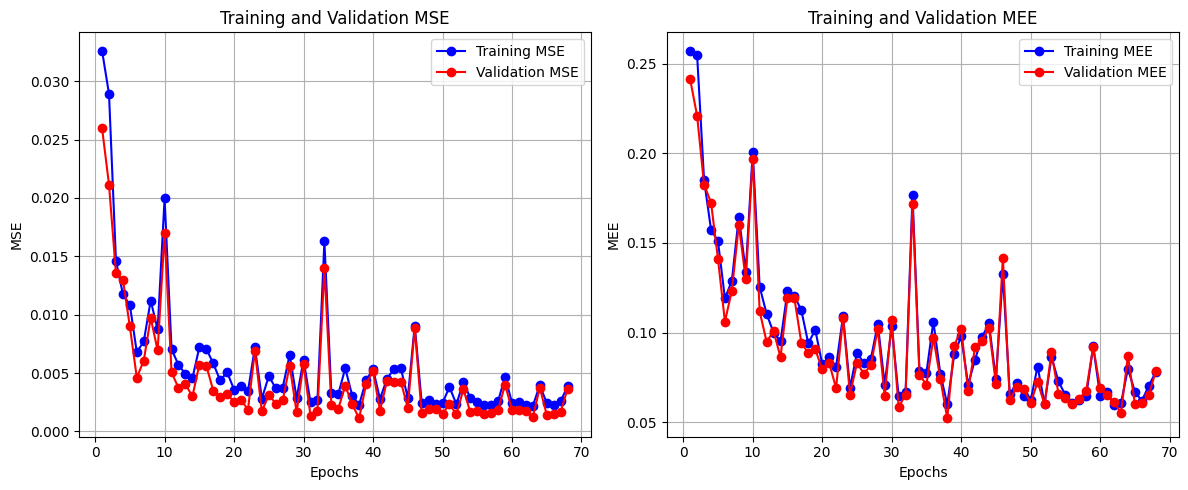

{'learning_rate': 0.1, 'epochs': 700, 'batch_size': 32, 'hidden_size': 80, 'hidden_layers': 3, 'momentum': 0.5, 'regularization': 0.01, 'alpha': 0.01, 'patience': 30}
Score: 0.058472392350865765


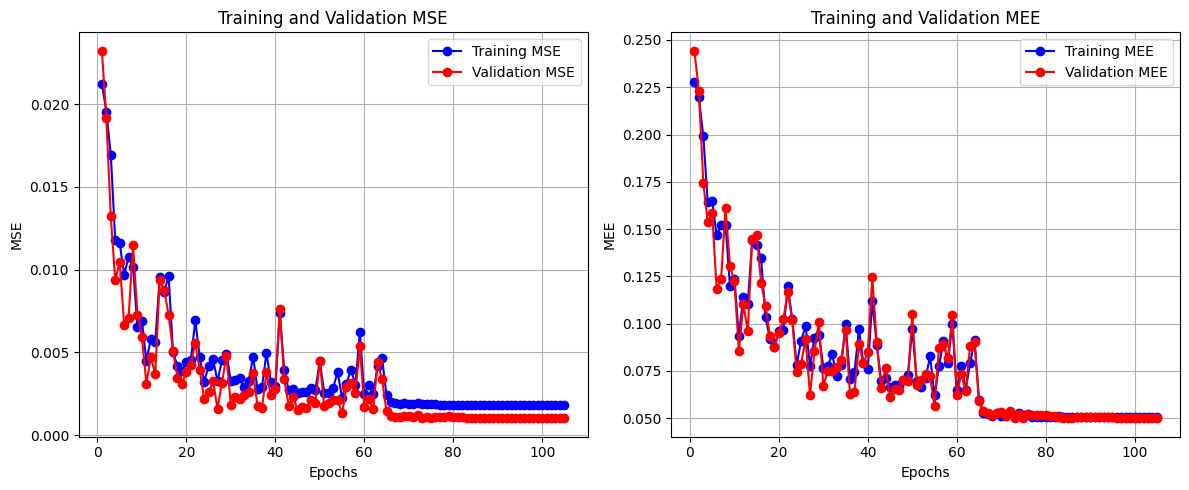

{'learning_rate': 0.1, 'epochs': 700, 'batch_size': 32, 'hidden_size': 70, 'hidden_layers': 3, 'momentum': 0.5, 'regularization': 0.01, 'alpha': 0.01, 'patience': 30}
Score: 0.05870465478885635


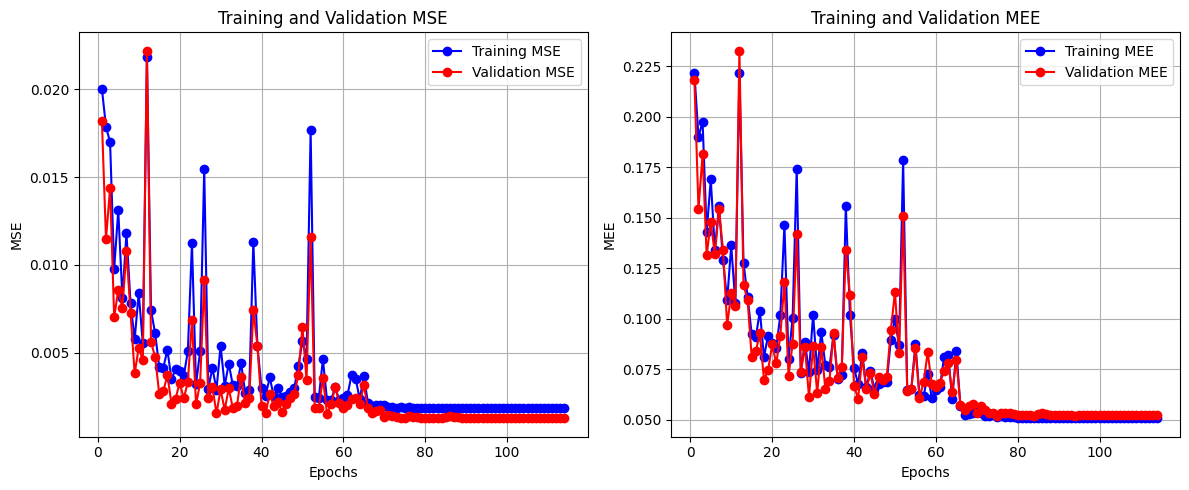

{'learning_rate': 0.1, 'epochs': 700, 'batch_size': 32, 'hidden_size': 80, 'hidden_layers': 3, 'momentum': 0.4, 'regularization': 0.01, 'alpha': 0.01, 'patience': 30}
Score: 0.05945256008064487


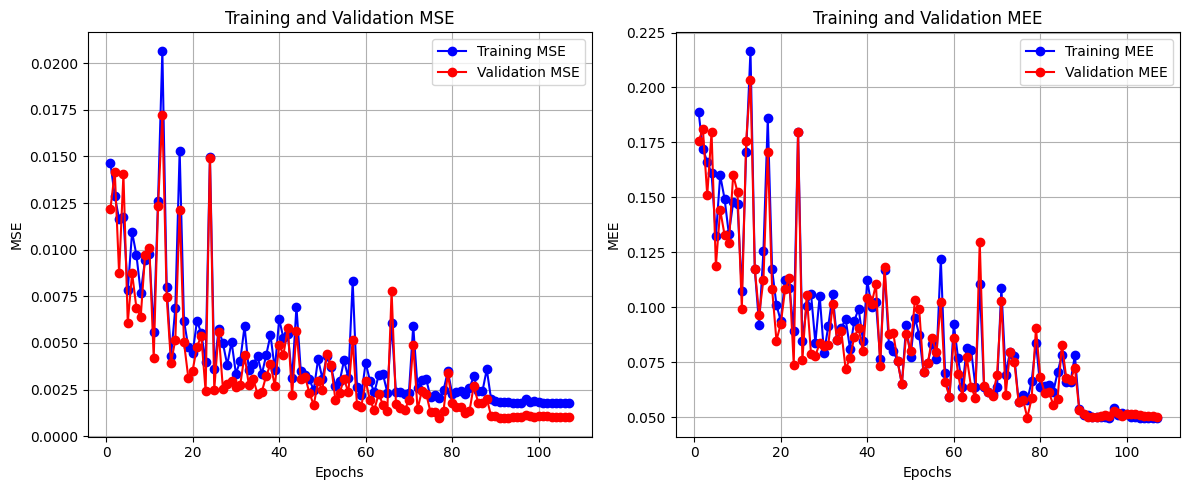

{'learning_rate': 0.1, 'epochs': 700, 'batch_size': 32, 'hidden_size': 60, 'hidden_layers': 3, 'momentum': 0.5, 'regularization': 0.01, 'alpha': 0.01, 'patience': 30}
Score: 0.05951964634460198


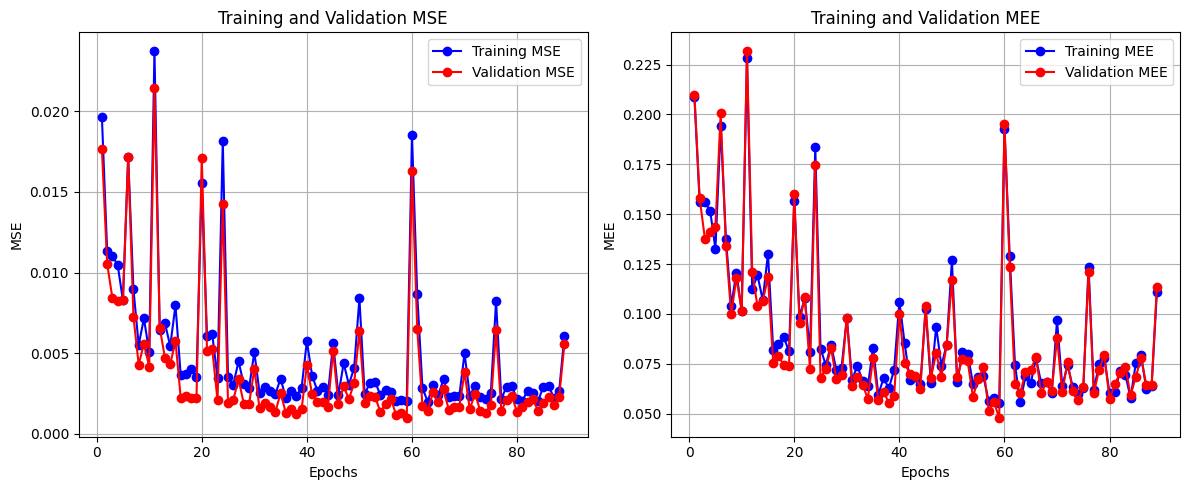

{'learning_rate': 0.1, 'epochs': 700, 'batch_size': 32, 'hidden_size': 70, 'hidden_layers': 2, 'momentum': 0.5, 'regularization': 0.01, 'alpha': 0.01, 'patience': 30}
Score: 0.059773638846938405


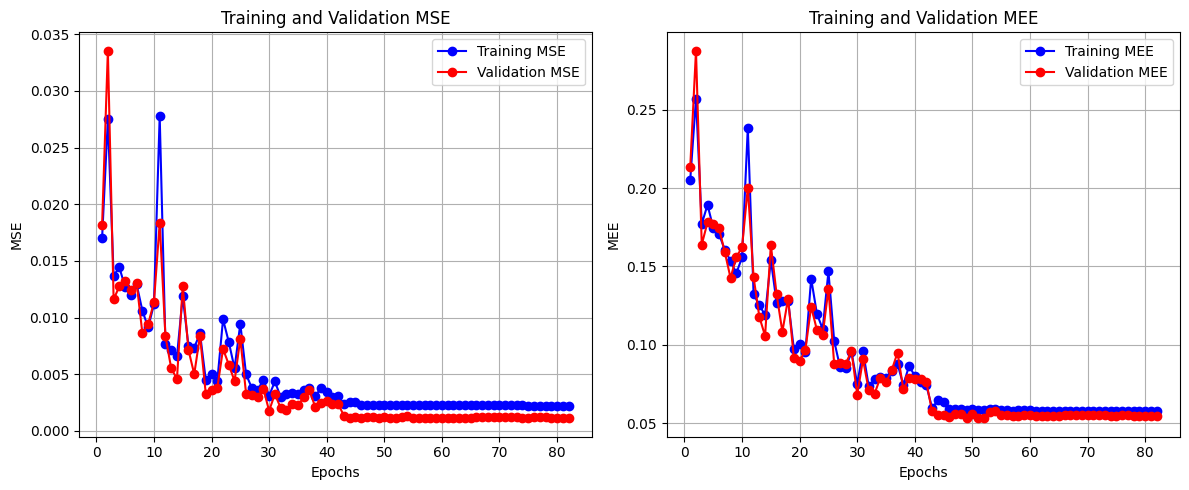

{'learning_rate': 0.1, 'epochs': 700, 'batch_size': 32, 'hidden_size': 50, 'hidden_layers': 3, 'momentum': 0.5, 'regularization': 0.01, 'alpha': 0.01, 'patience': 30}
Score: 0.060101839421196276


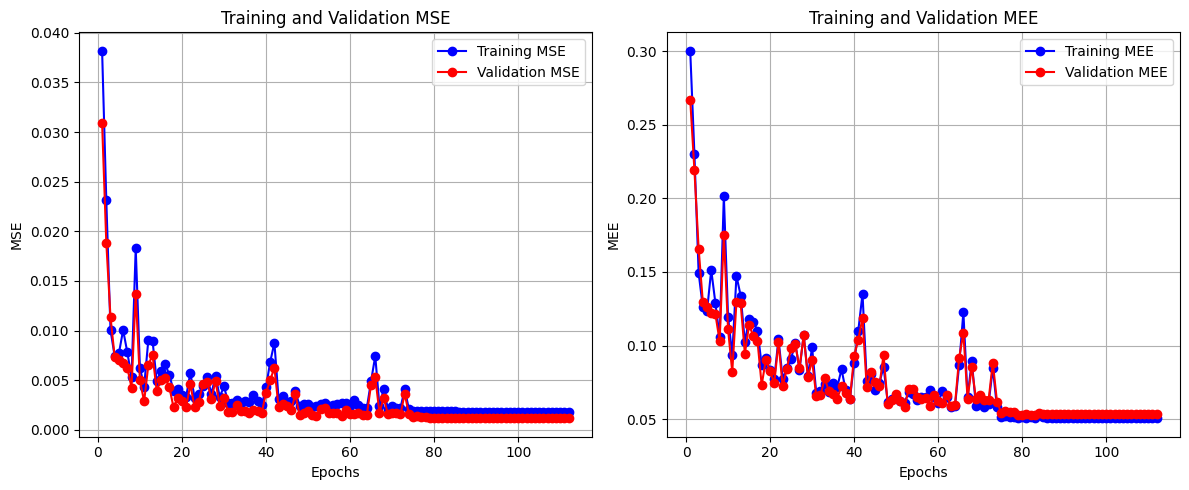

{'learning_rate': 0.1, 'epochs': 700, 'batch_size': 32, 'hidden_size': 70, 'hidden_layers': 3, 'momentum': 0.4, 'regularization': 0.01, 'alpha': 0.01, 'patience': 30}
Score: 0.06024849876747853


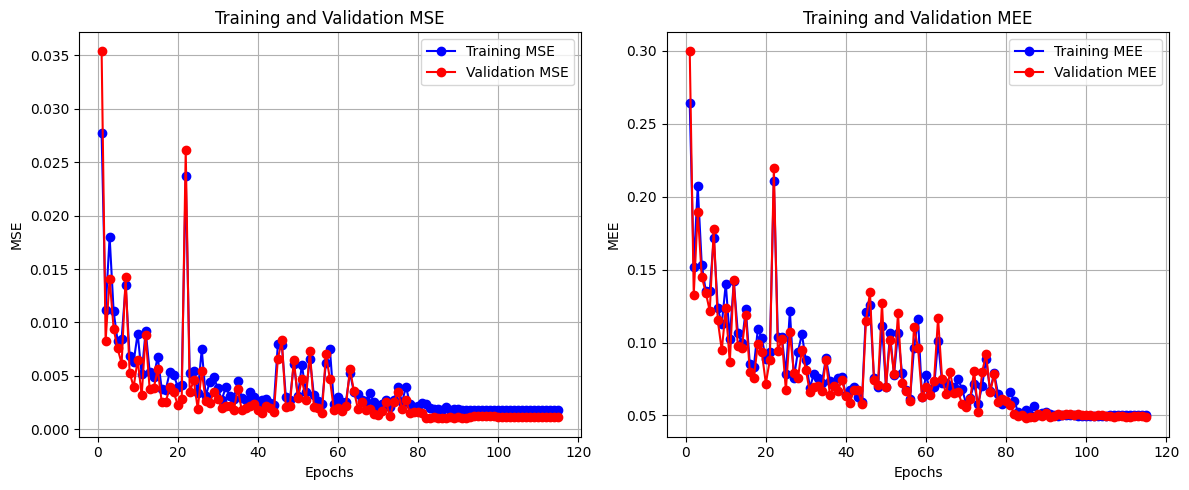

{'learning_rate': 0.1, 'epochs': 700, 'batch_size': 32, 'hidden_size': 70, 'hidden_layers': 2, 'momentum': 0.4, 'regularization': 0.01, 'alpha': 0.01, 'patience': 30}
Score: 0.06162703164373236


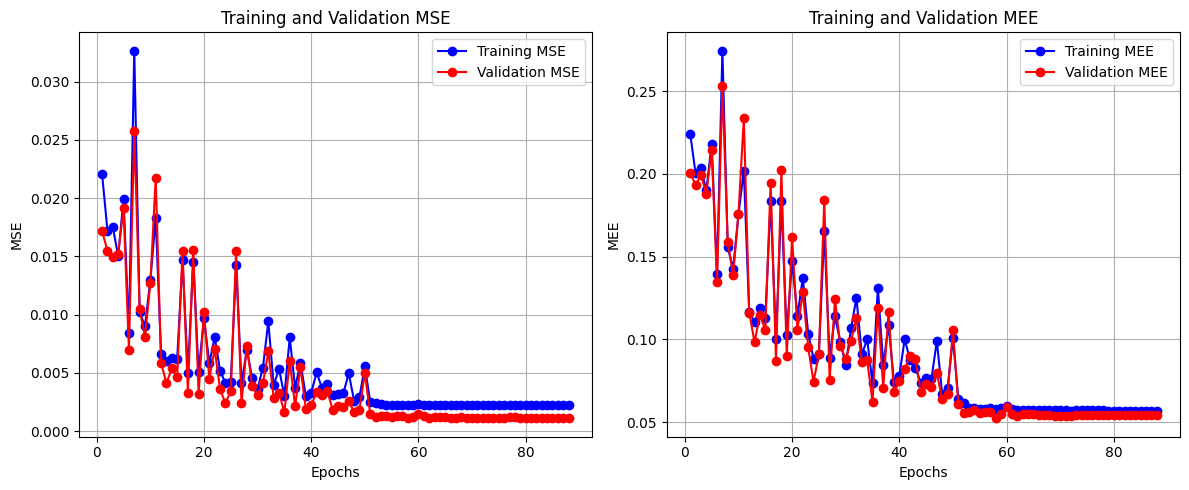

{'learning_rate': 0.1, 'epochs': 700, 'batch_size': 32, 'hidden_size': 80, 'hidden_layers': 2, 'momentum': 0.5, 'regularization': 0.01, 'alpha': 0.01, 'patience': 30}
Score: 0.06171152154269235


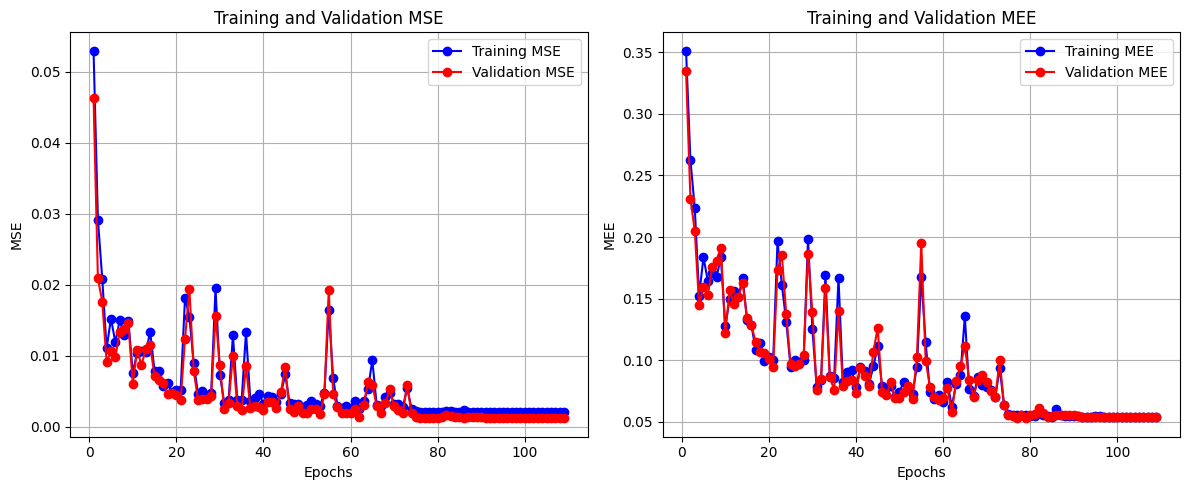

In [ ]:

print("--------------------------------------------------Plots--------------------------------------------------")
for i, (history, params, score) in enumerate(zip(best_histories, best_params_list, best_scores)):
    print(f"{params}")
    print(f"Score: {score}")
    plot_training_history(history)